## Purpose

This notebook's purpose is to extract a short sample out of the reviews csv and then manually annotate the sample so that we can feed into the Keras Bi-LSTM model to be re-trained on top of the pre-annotated dataset.

## Imports

In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

In [2]:
# Imports for pre-processing
import regex as re

## Load Data / Data Cleaning / Pre-processing

In [3]:
# Import csv
review = pd.read_csv('../../data/cleaned_review.csv')
review = review.drop(columns=['nltk','spacy','spacy_retrain','lstm'])

In [4]:
# List of some local places on top of the places that we were interested in (evaluated places)
local_list = ['RWS','MBS','Marina Barrage','Hougang','Punggol','Clementi','Beauty World',
              'Marina Bay Sands','Jewel','Jewel Changi','Madame Tussauds Singapore',
              'Universal Studios Singapore','S.E.A. Aquarium','Wild Wild Wet','Zero Latency',
              'East Coast Park','Marina Bay','Palawan Beach','Siloso Beach','Changi Beach',
              'China Cultural Centre','Science Centre Singapore','Singapore Discovery Centre',
              'ArtScience Museum','Boat Quay','Clarke Quay','Bukit Timah','Mount Faber','Baba House',
              'City Hall','Fort Canning','Fort Siloso','Raffles Hotel','Marina Barrage','URA City Gallery',
              'Sungei Buloh Wetland Reserve','Sultan Mosque','Resorts World Sentosa',
              'Arab Street','Bugis Street','Chinatown','Little India','National Stadium',
              'Singapore Indoor Stadium','Esplanade','Haw Par Villa','Adventure Cove',
              'Universal Studios Singapore','Wild Wild Wet','Jurong Bird Park','Night Safari','River Safari',
              'Singapore Zoo','Fort Canning Park','Bukit Timah Nature Reserve','Hong Lim Park',
              'MacRitchie Reservoir Park','Pulau Ubin','Singapore Botanic Gardens','Southern Ridges',
              'Sim Lim','313 Somerset','Bugis Junction','Tekka Place','Orchard Towers',
              'Changi City Point','Golden Mile Complex','Orchard','Somerset','Dhoby Ghaut','Raffles Place',
              'Marina South Pier','Kallang','Bugis','Tanjong Pagar','Outram Park','Tiong Bahru','Redhill',
              'Harbourfront','Farrer Park','Promenade','Stadium','Holland Village',
              'Bayfront','Botanic Gardens','Telok Ayer','Jalan Besar']

In [5]:
# Create df
sample_size = pd.DataFrame()

In [6]:
# Add reviews that contain the selected places in list into the sample_size df
for i in local_list:
    sample_size = sample_size.append(review[review['re_comments'].str.contains(i)])

In [7]:
# Check length of sample
sample_size.shape

(4745, 9)

In [8]:
# Check random sample of size 10
sample_size.sample(10)

,listing_id,id,date,reviewer_id,reviewer_name,comments,length,language,re_comments
15133,9635192,324846743,2018-09-18,178751078,Wichaya,"Really nice place to stay, and great location....",271,en,"Really nice place to stay, and great location...."
24732,17657915,432443430,2019-04-04,3035809,Tim,A decent budget option. The sleeping quarters...,63,en,A decent budget option. The sleeping quarters...
18836,12162272,585653157,2020-01-01,78592878,Scott,Angelina's place was perfect for us. We stayed...,83,en,Angelina's place was perfect for us. We stayed...
15834,9967697,579576335,2019-12-21,11820016,Lea,"L’auberge est top. Silencieuse, propre, flexib...",38,fr,"The hostel is top. Silent, clean, flexible at ..."
17664,11381088,108336181,2016-10-15,95691805,Summer,"Such a lovely place ! everything is perfect , ...",46,en,"Such a lovely place ! everything is perfect , ..."
6785,5355795,526517982,2019-09-09,187997397,Chris,Preis Leistung ist super !\nMetro Station vor ...,28,de,Price performance is great! Metro station in ...
13089,8196417,129595122,2017-01-31,110379662,Cecilia Mae,Very good location to go around Singapore. MRT...,38,en,Very good location to go around Singapore. MRT...
26578,19595827,201263920,2017-10-08,112352013,Alison,"Enjoyed a lovely, comfortable stay at Kay's pl...",85,en,"Enjoyed a lovely, comfortable stay at Kay's pl..."
33831,26309079,356683560,2018-12-09,81858731,David,"Overall, a good spot to stay if you want to be...",71,en,"Overall, a good spot to stay if you want to be..."
21889,15722934,275862843,2018-06-12,24798698,Sandrine,I went several time to Alex location. It is ne...,19,en,I went several time to Alex location. It is ne...


In [9]:
# Get only samples with length of less than 100
sample_size = sample_size[sample_size['length']<100]

In [10]:
# Dictionary of English contractions
contractions_dict = { "ain't": "are not","'s":" is","aren't": "are not",
                     "can't": "cannot","can't've": "cannot have",
                     "'cause": "because","could've": "could have","couldn't": "could not",
                     "couldn't've": "could not have", "didn't": "did not","doesn't": "does not",
                     "don't": "do not","hadn't": "had not","hadn't've": "had not have",
                     "hasn't": "has not","haven't": "have not","he'd": "he would",
                     "he'd've": "he would have","he'll": "he will", "he'll've": "he will have",
                     "how'd": "how did","how'd'y": "how do you","how'll": "how will",
                     "I'd": "I would", "I'd've": "I would have","I'll": "I will",
                     "I'll've": "I will have","I'm": "I am","I've": "I have", "isn't": "is not",
                     "it'd": "it would","it'd've": "it would have","it'll": "it will",
                     "it'll've": "it will have", "let's": "let us","ma'am": "madam",
                     "mayn't": "may not","might've": "might have","mightn't": "might not", 
                     "mightn't've": "might not have","must've": "must have","mustn't": "must not",
                     "mustn't've": "must not have", "needn't": "need not",
                     "needn't've": "need not have","o'clock": "of the clock","oughtn't": "ought not",
                     "oughtn't've": "ought not have","shan't": "shall not","sha'n't": "shall not",
                     "shan't've": "shall not have","she'd": "she would","she'd've": "she would have",
                     "she'll": "she will", "she'll've": "she will have","should've": "should have",
                     "shouldn't": "should not", "shouldn't've": "should not have","so've": "so have",
                     "that'd": "that would","that'd've": "that would have", "there'd": "there would",
                     "there'd've": "there would have", "they'd": "they would",
                     "they'd've": "they would have","they'll": "they will",
                     "they'll've": "they will have", "they're": "they are","they've": "they have",
                     "to've": "to have","wasn't": "was not","we'd": "we would",
                     "we'd've": "we would have","we'll": "we will","we'll've": "we will have",
                     "we're": "we are","we've": "we have", "weren't": "were not","what'll": "what will",
                     "what'll've": "what will have","what're": "what are", "what've": "what have",
                     "when've": "when have","where'd": "where did", "where've": "where have",
                     "who'll": "who will","who'll've": "who will have","who've": "who have",
                     "why've": "why have","will've": "will have","won't": "will not",
                     "won't've": "will not have", "would've": "would have","wouldn't": "would not",
                     "wouldn't've": "would not have","y'all": "you all", "y'all'd": "you all would",
                     "y'all'd've": "you all would have","y'all're": "you all are",
                     "y'all've": "you all have", "you'd": "you would","you'd've": "you would have",
                     "you'll": "you will","you'll've": "you will have", "you're": "you are",
                     "you've": "you have"}

# Regular expression for finding contractions
contractions_re=re.compile('(%s)' % '|'.join(contractions_dict.keys()))

# Replace contractions with full words
def expand_contractions(text,contractions_dict=contractions_dict):
    def replace(match):
        return contractions_dict[match.group(0)]
    return contractions_re.sub(replace, text)

In [11]:
# Create function to preprocess the sentences 
def review_to_words(review_text):

    # Remove word contractions
    review_text = expand_contractions(review_text)
    
    # Remove non-letters.
    review_text = re.sub("[^a-zA-Z0-9.,]", " ", review_text)
    
    # Add space in fron of comma to retain comma after split
    review_text = review_text.replace(',',' ,')
    review_text = review_text.replace('.',' .')
    
    # Split into individual words.
    words = review_text.split()
    
    return (words)

In [12]:
# Run the function across the reviews of sample size = 125
samples = [review_to_words(s) for s in sample_size.sample(125)['re_comments']]

In [13]:
# Check the first review sample
samples[0]

['This',
 'was',
 'a',
 'great',
 'place',
 'to',
 'stay',
 'The',
 'host',
 'was',
 'friendly',
 'and',
 'welcoming',
 'and',
 'the',
 'room',
 'was',
 'very',
 'comfortable',
 '.',
 'Moreover',
 'the',
 'location',
 'was',
 'perfect',
 'there',
 'was',
 'so',
 'much',
 'to',
 'see',
 'within',
 'walking',
 'distance',
 'in',
 'Chinatown',
 ',',
 'and',
 'the',
 'apartment',
 'was',
 'also',
 'right',
 'on',
 'top',
 'of',
 'the',
 'Chinatown',
 'MRT',
 'station',
 ',',
 'giving',
 'easy',
 'access',
 'to',
 'the',
 'whole',
 'city',
 '.',
 'Highly',
 'recommended']

In [14]:
# Check length of sample list
len(samples)

125

In [15]:
# Create a df
sample_train = pd.DataFrame()

# Add list into df
sample_train['sentence'] = samples

# Number the reviews so that we can expand and merge in further steps
sample_train['num'] = [i+1 for i in range(len(samples))]

# Rearrange column and check df
sample_train = sample_train[['num', 'sentence']]
sample_train.head()

,num,sentence
0,1,"[This, was, a, great, place, to, stay, The, ho..."
1,2,"[Value, for, money, ,, walking, distance, to, ..."
2,3,"[I, was, transferred, to, the, Tanjong, Pagar,..."
3,4,"[Great, staff, and, nice, place, ., The, photo..."
4,5,"[I, had, a, nice, stay, at, Atlantis, Pods, Ch..."


In [16]:
# Un-nest the words inside the sentence column so that we can perform manual annotation
sample_train = sample_train.explode('sentence')

# Check df
sample_train.head()

,num,sentence
0,1,This
0,1,was
0,1,a
0,1,great
0,1,place


In [17]:
# Due to run-ability check and re-run purpose, below code is masked out

# Essentially, we will export the csv to perform manual annotation

sample_train.to_csv('../../data/manual_annotate_sample.csv')

## Manual Annotation

After export to csv, we will use excel to perform manual annotation in new 'tag' column, then re-import again using the same csv file

<img src="../../images/manual_anno_shot.png" width="200">

Manual annotation will be based on IOB format with tags similar to the pre-annotated dataset.

Available tags:  
geo / gpe / org / per / tim / eve / art

IOB format prefix:  
B - beginning  
I - inside  
O - outside  

Due to class imbalance (majority is O), 'O' will not be labelled and just filled in with Python .fillna instead

In [19]:
# After manual annotation, reload the csv file
sample_train = pd.read_csv('../../data/manual_annotate_sample.csv')

In [20]:
# Fill NA with 'O' as mentioned
sample_train.drop(columns='Unnamed: 0',inplace=True)
sample_train.fillna('O', inplace=True)

In [21]:
# Check df
sample_train.head()

,num,sentence,tag
0,1,This,O
1,1,was,O
2,1,a,O
3,1,great,O
4,1,place,O


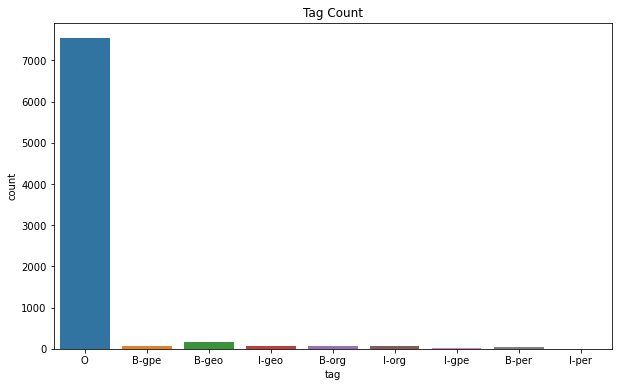

In [22]:
# Check distribution of tags
fig = plt.figure(figsize=(10,6))
sns.countplot(data=sample_train, x='tag')
plt.title('Tag Count');

Similar to our pre-annotated dataset, there is a huge imbalance of class 'O'. Hence, we will need to rely on other metrics such as recall or precision or f1 in the later stages.

In [23]:
# Save the final sample df to be used in the LSTM model (masked out due to re-run purpose)

#sample_train.to_csv('../../data/manual_annotate_sample.csv')